In [1]:
# Data Source
# 1. CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html Accessed on 2024 11 11
#   - Files: data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, test_batch
#   - Renamed to: cifar10-train-1, cifar10-train-2, cifar10-train-3, cifar10-train-4, cifar10-train-5, cifar10-test

# 2. Fashion-MNIST: https://github.com/zresearch/fashion-mnist Accessed on 2024 11 11
#   - Files: train-images-idx3-ubyte, train-labels-idx1-ubyte, t10k-images-idx3-ubyte, t10k-labels-idx1-ubyte
#   - Renamed to: fmnist-train-image, fmnist-train-label, fmnist-test-image, fmnist-test-label

In [2]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools.dist  # To avoid tensorflow import error for distutils, requires setuptools to be installed
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-11-15 00:09:12.255152: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 00:09:12.277058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731600552.297681  128917 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731600552.303248  128917 cuda_blas.cc:1418] Unable to register cuBL

CIFAR-10
Train Data | Label : (50000, 3072)  |  (50000,)
Test Data | Label : (10000, 3072)  |  (10000,)
Fashion MNIST
Train Data | Label : (60000, 784)  |  (60000,)
Test Data | Label : (10000, 784)  |  (10000,)
CIFAR-10


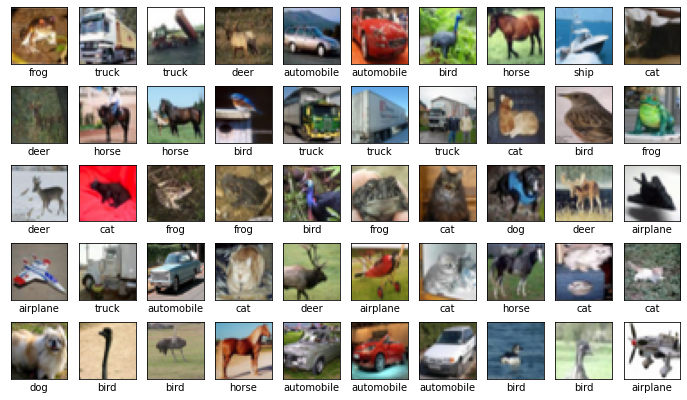

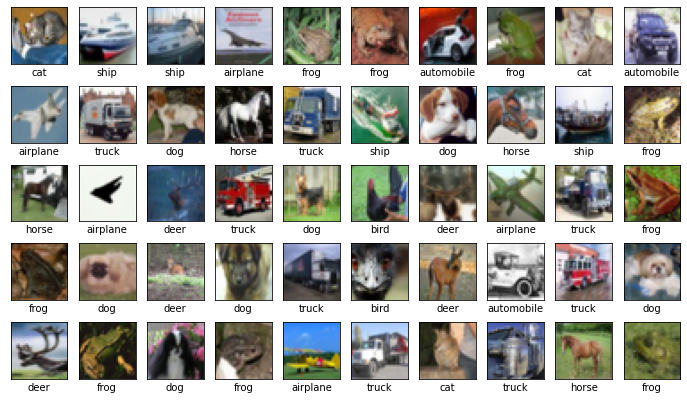

Fashion MNIST


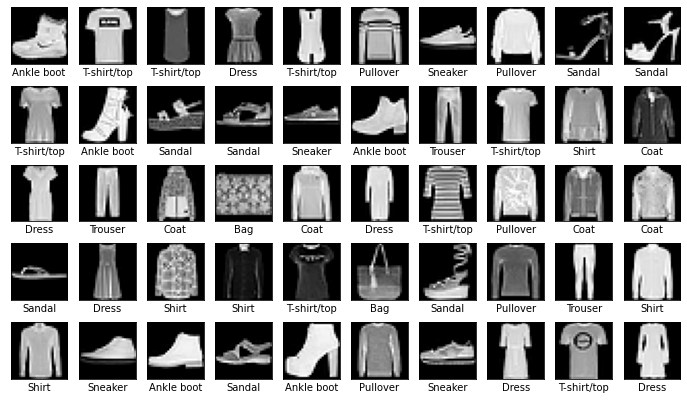

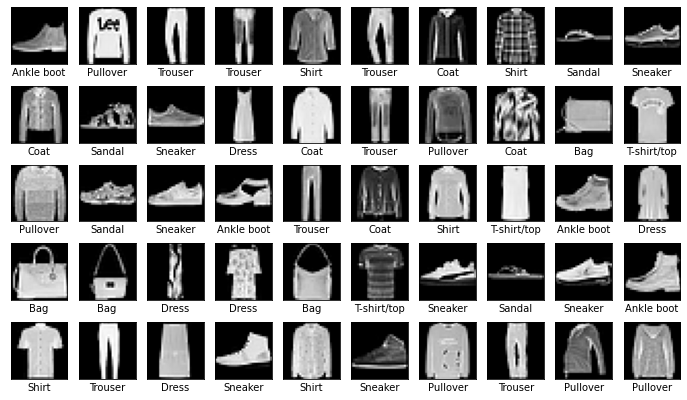

In [3]:
# ==================================================================================================== Step 1. Loading Data
# 1. CIFAR-10 Ref: https://www.cs.toronto.edu/~kriz/cifar.html
# CIFAR-10 Class Label
cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


# For loading pickle files. From https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict


# Data Frame for CIFAR-10
cifar10_train_data = []
cifar10_train_label = []

cifar10_test_data = []
cifar10_test_label = []


# 1.1 Load Train Data
for i in range(1, 6):
    file = f"./data/cifar10-train-{i}"
    cifar10_test_file = unpickle(file)
    cifar10_train_data.append(cifar10_test_file[b"data"])
    cifar10_train_label.append(cifar10_test_file[b"labels"])

cifar10_train_data = np.concatenate(cifar10_train_data)
cifar10_train_label = np.concatenate(cifar10_train_label)


# 1.2 Load Test Data
cifar10_test_file = unpickle("./data/cifar10-test")
cifar10_test_data.append(cifar10_test_file[b"data"])
cifar10_test_label.append(cifar10_test_file[b"labels"])
cifar10_test_data = np.concatenate(cifar10_test_data)
cifar10_test_label = np.concatenate(cifar10_test_label)


# 2. Fashion-MNIST Ref: https://pjreddie.com/projects/mnist-in-csv/ , https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
# Fashion MNIST Class Label
fmnist_classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


# For converting idx to csv
def idx2csv(image_file, label_file, output_file):
    with open(image_file, "rb") as f:
        image_data = f.read()

    with open(label_file, "rb") as f:
        label_data = f.read()

    # Skip header
    image_data = image_data[16:]
    label_data = label_data[8:]
    image_length = len(image_data) // 784  # 28x28 = 784
    label_length = len(label_data)  # 1 byte per label
    images = np.zeros((image_length, 784), dtype=np.uint8)  # 28x28 = 784
    labels = np.zeros((label_length), dtype=np.uint8)  # 1 byte per label

    # i = image index, j = pixel index
    for i in range(image_length):
        for j in range(784):
            images[i, j] = image_data[i * 784 + j]  # 28x28 = 784

    # i = label index
    for i in range(label_length):
        labels[i] = label_data[i]  # 1 byte per label

    # Save to csv
    np.savetxt(
        output_file,
        np.concatenate((labels.reshape(-1, 1), images), axis=1),
        delimiter=",",
        fmt="%d",
    )


# 2.1 Convert idx to csv
if not os.path.exists("./data/fmnist-train.csv"):
    idx2csv("./data/fmnist-train-image", "./data/fmnist-train-label", "./data/fmnist-train.csv")
if not os.path.exists("./data/fmnist-test.csv"):
    idx2csv("./data/fmnist-test-image", "./data/fmnist-test-label", "./data/fmnist-test.csv")

# 2.2 Load Data
fmnist_train_data = pd.read_csv("./data/fmnist-train.csv", header=None).loc[:, 1:].values
fmnist_train_label = pd.read_csv("./data/fmnist-train.csv", header=None).loc[:, 0].values
fmnist_test_data = pd.read_csv("./data/fmnist-test.csv", header=None).loc[:, 1:].values
fmnist_test_label = pd.read_csv("./data/fmnist-test.csv", header=None).loc[:, 0].values


# 3. Display Data
# 3.1 Display Data Shape
print("CIFAR-10")
print("Train Data | Label :", cifar10_train_data.shape, " | ", cifar10_train_label.shape)
print("Test Data | Label :", cifar10_test_data.shape, " | ", cifar10_test_label.shape)
print("Fashion MNIST")
print("Train Data | Label :", fmnist_train_data.shape, " | ", fmnist_train_label.shape)
print("Test Data | Label :", fmnist_test_data.shape, " | ", fmnist_test_label.shape)

# 3.2 Display image with label and class
# CIFAR-10
print("CIFAR-10")
plt.figure(figsize=(12, 7))
plt.title("CIFAR-10 Train Data")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_train_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(cifar10_classes[cifar10_train_label[i]])
plt.savefig("./figures/1 cifar10_train_data.jpg", dpi=600)
plt.show()

plt.figure(figsize=(12, 7))
plt.title("CIFAR-10 Test Data")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_test_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(cifar10_classes[cifar10_test_label[i]])
plt.savefig("./figures/1 cifar10_test_data.jpg", dpi=600)
plt.show()

# Fashion MNIST
print("Fashion MNIST")
plt.figure(figsize=(12, 7))
plt.title("Fashion MNIST Train Data")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_train_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(fmnist_classes[fmnist_train_label[i]])
plt.savefig("./figures/1 fmnist_train_data.jpg", dpi=600)
plt.show()

plt.figure(figsize=(12, 7))
plt.title("Fashion MNIST Test Data")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_test_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(fmnist_classes[fmnist_test_label[i]])
plt.savefig("./figures/1 fmnist_test_data.jpg", dpi=600)
plt.show()

In [4]:
# ==================================================================================================== Step 2. Data Preprocessing
# 1. CIFAR-10
# 1.1 Normalization
cifar10_train_data_normed = cifar10_train_data / 255.0
cifar10_test_data_normed = cifar10_test_data / 255.0

# 1.2 Reshape
cifar10_train_data_normed = cifar10_train_data_normed.reshape(-1, 32, 32, 3)  # 3 for RGB
cifar10_test_data_normed = cifar10_test_data_normed.reshape(-1, 32, 32, 3)  # 3 for RGB

# 2. Fashion-MNIST
# 2.1 Normalization
fmnist_train_data_normed = fmnist_train_data / 255.0
fmnist_test_data_normed = fmnist_test_data / 255.0

# 2.2 Reshape
fmnist_train_data_normed = fmnist_train_data_normed.reshape(-1, 28, 28, 1)  # 1 for grayscale
fmnist_test_data_normed = fmnist_test_data_normed.reshape(-1, 28, 28, 1)  # 1 for grayscale


# 3. Check data shape before and after normalization
print("CIFAR-10 - Train Original Shape:", cifar10_train_data.shape, " | Normalized Shape:", cifar10_train_data_normed.shape)
print("CIFAR-10 - Test Original Shape:", cifar10_test_data.shape, " | Normalized Shape:", cifar10_test_data_normed.shape)
print("Fashion MNIST - Train Original Shape:", fmnist_train_data.shape, " | Normalized Shape:", fmnist_train_data_normed.shape)
print("Fashion MNIST - Test Original Shape:", fmnist_test_data.shape, " | Normalized Shape:", fmnist_test_data_normed.shape)

# 4. Verify content of data
print("CIFAR-10 - Train Data")
print(cifar10_train_data[1])
print("CIFAR-10 - Train Data Normalized")
print(cifar10_train_data_normed[1])
print("Fashion MNIST - Train Data")
print(fmnist_train_data[1])
print("Fashion MNIST - Train Data Normalized")
print(fmnist_train_data_normed[1])

CIFAR-10 - Train Original Shape: (50000, 3072)  | Normalized Shape: (50000, 32, 32, 3)
CIFAR-10 - Test Original Shape: (10000, 3072)  | Normalized Shape: (10000, 32, 32, 3)
Fashion MNIST - Train Original Shape: (60000, 784)  | Normalized Shape: (60000, 28, 28, 1)
Fashion MNIST - Test Original Shape: (10000, 784)  | Normalized Shape: (10000, 28, 28, 1)
CIFAR-10 - Train Data
[154 126 105 ... 139 142 144]
CIFAR-10 - Train Data Normalized
[[[0.60392157 0.49411765 0.41176471]
  [0.4        0.49019608 0.60784314]
  [0.6745098  0.70588235 0.55686275]
  ...
  [0.34509804 0.40392157 0.36862745]
  [0.25490196 0.3254902  0.35294118]
  [0.30980392 0.26666667 0.2627451 ]]

 [[0.53333333 0.5372549  0.47843137]
  [0.51764706 0.59215686 0.70980392]
  [0.79607843 0.81568627 0.81568627]
  ...
  [0.36078431 0.34509804 0.30588235]
  [0.34117647 0.38431373 0.29803922]
  [0.2627451  0.31764706 0.35686275]]

 [[0.57254902 0.48627451 0.34509804]
  [0.33333333 0.34117647 0.32941176]
  [0.29411765 0.30588235 0.

In [5]:
# Model architecture
# 1. Basic architecture
# Input Layer > Conv2D > MaxPooling2D > Conv2D > MaxPooling2D > Flatten > Dense > Output Layer

# 2. Model architecture from Kaggle
# CIFAR-10: https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer
# Model: Conv2D > Conv2D > MaxPooling2D > Dropout > Conv2D > Conv2D > MaxPooling2D > Dropout > Flatten > Dense > Dropout > Dense

# CIFAR-10: https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook
# Model: Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Flatten > Dense > BatchNorm > Dropout > Dense

# Fashion MNIST: https://www.kaggle.com/code/pavansanagapati/a-simple-cnn-model-beginner-guide
# Model: Conv2D > MaxPooling2D > Dropout > Flatten > Dense > Dense

# Fashion MNIST: https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
# Model: Conv2D > conv2D > MaxPooling2D > Flatten > Dense > Dropout > Dense > Dense

# 3. Proposed Model - basic (single model for both CIFAR and Fashion MNIST)
# Model: Conv2D > MaxPooling2D > Conv2D > MaxPooling2D > Flatten > Dense > Dense

# 4. Proposed Model - advanced (single model (with underfitting and overfitting handling + k-fold cross validation) for both CIFAR and Fashion MNIST)
# Model: Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Conv2D > BatchNorm > Conv2D > BatchNorm > MaxPooling2D > Dropout > Flatten > Dense > BatchNorm > Dropout > Dense

# Method for addressing Underfitting and Overfitting
# 1. General: Learning rate, epochs
# 2. Underfitting: Data augmentation (rotation, flip, zoom, shift)
# 3. Overfitting handling: Dropout, l2 regularization, BatchNormalization

In [6]:
# ==================================================================================================== Step 3. Model Building
# 1. Model Building
# 1.1 Basic Model
def build_basic_model(input_shape, num_classes):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model


# 1.2 Advanced Model
def build_advanced_model(input_shape, num_classes):
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model


# 2. Model Compilation
# 2.1 Basic Model
basic_model_cifar = build_basic_model((32, 32, 3), 10)
basic_model_cifar.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
basic_model_fmnist = build_basic_model((28, 28, 1), 10)
basic_model_fmnist.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

# 2.2 Advanced Model
advanced_model_cifar = build_advanced_model((32, 32, 3), 10)
advanced_model_cifar.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
advanced_model_fmnist = build_advanced_model((28, 28, 1), 10)
advanced_model_fmnist.compile(optimizer="adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

# 2.3 Model Summary
print("Basic Model - CIFAR")
basic_model_cifar.summary()
print("Basic Model - Fashion MNIST")
basic_model_fmnist.summary()
print("Advanced Model - CIFAR")
advanced_model_cifar.summary()
print("Advanced Model - Fashion MNIST")
advanced_model_fmnist.summary()

/home/pinchee/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731600569.398790  128917 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13687 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Basic Model - CIFAR


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Basic Model - Fashion MNIST


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Advanced Model - CIFAR


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Advanced Model - Fashion MNIST


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 437,610 (1.67 MB)

 Trainable params: 436,458 (1.66 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [7]:
# ==================================================================================================== Step 4. Model Training
# 1. Set early stopping and checkpoint
n_folds = 5
epochs = 100
batch_size = 64
model_history_cifar10_basic = []
model_history_cifar10_advance = []
model_history_fmnist_basic = []
model_history_fmnist_advance = []

pat = 80  # Number of epochs with no improvement after which training will be stopped
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Set checkpoint
cifar10_basic_checkpoint_path = "./model/cifar10_basic_model.keras"
cifar10_advance_checkpoint_path = "./model/cifar10_advance_model.keras"
cifar10_basic_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=cifar10_basic_checkpoint_path, save_best_only=True, verbose=1)
cifar10_advance_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=cifar10_advance_checkpoint_path, save_best_only=True, verbose=1)
fmnist_basic_checkpoint_path = "./model/fmnist_basic_model.keras"
fmnist_advance_checkpoint_path = "./model/fmnist_advance_model.keras"
fmnist_basic_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fmnist_basic_checkpoint_path, save_best_only=True, verbose=1)
fmnist_advance_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fmnist_advance_checkpoint_path, save_best_only=True, verbose=1)


# Define fit function
def fit_and_evaluate(model, model_checkpoint, train_data, train_label, test_data, test_label, epochs, batch_size):
    history = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.1)
    print("Validation Accuracy: ", model.evaluate(test_data, test_label))
    return history


# 2. Model Training
# 1.1 Basic Model
# CIFAR-10
model_history_cifar10_basic.append(fit_and_evaluate(basic_model_cifar, cifar10_basic_cp_callback, cifar10_train_data_normed, cifar10_train_label, cifar10_test_data_normed, cifar10_test_label, epochs, batch_size))
model_history_fmnist_basic.append(fit_and_evaluate(basic_model_fmnist, fmnist_basic_cp_callback, fmnist_train_data_normed, fmnist_train_label, fmnist_test_data_normed, fmnist_test_label, epochs, batch_size))

# 1.2 Advanced Model with K-Fold Cross Validation
# CIFAR-10
for i in range(n_folds):
    print("Training CIFAR-10 on Fold: ", i + 1)
    t_x, val_x, t_y, val_y = train_test_split(cifar10_train_data_normed, cifar10_train_label, test_size=0.1, random_state=np.random.randint(1, 1000, 1)[0])
    model_history_cifar10_advance.append(fit_and_evaluate(advanced_model_cifar, cifar10_advance_cp_callback, t_x, t_y, val_x, val_y, epochs, batch_size))
    print("END ==========================================================================")

# Fashion MNIST
for i in range(n_folds):
    print("Training Fashion MNIST on Fold: ", i + 1)
    t_x, val_x, t_y, val_y = train_test_split(fmnist_train_data_normed, fmnist_train_label, test_size=0.1, random_state=np.random.randint(1, 1000, 1)[0])
    model_history_fmnist_advance.append(fit_and_evaluate(advanced_model_fmnist, fmnist_advance_cp_callback, t_x, t_y, val_x, val_y, epochs, batch_size))
    print("END ==========================================================================")

# 3. Save Model
basic_model_cifar.save("./model/cifar10_basic_model.h5")
basic_model_fmnist.save("./model/fmnist_basic_model.h5")
advanced_model_cifar.save("./model/cifar10_advance_model.h5")
advanced_model_fmnist.save("./model/fmnist_advance_model.h5")

Epoch 1/100


I0000 00:00:1731600572.729966  129233 service.cc:148] XLA service 0x7fd14401bb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731600572.730082  129233 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-11-15 00:09:32.761010: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731600572.896429  129233 cuda_dnn.cc:529] Loaded cuDNN version 90300


 11/704 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.1365 - loss: 2.3483 

I0000 00:00:1731600575.228751  129233 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3242 - loss: 1.8545
Epoch 1: val_loss improved from inf to 1.34170, saving model to ./model/cifar10_basic_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3243 - loss: 1.8542 - val_accuracy: 0.5142 - val_loss: 1.3417
Epoch 2/100
692/704 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5325 - loss: 1.3217
Epoch 2: val_loss improved from 1.34170 to 1.21859, saving model to ./model/cifar10_basic_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5329 - loss: 1.3207 - val_accuracy: 0.5802 - val_loss: 1.2186
Epoch 3/100
697/704 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5911 - loss: 1.1650
Epoch 3: val_loss improved from 1.21859 to 1.10389, saving model to ./model/cifar10_basic_model.keras
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5912 - loss: 1.1648 - val_accuracy: 0.6182 - val_loss: 1.1039
Epoch 4/100
699/704 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6265 - loss: 1.0641
Epoch 4:

2024-11-15 00:18:26.935929: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66', 4 bytes spill stores, 4 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 4.8001
Validation Accuracy:  [4.897382736206055, 0.5967000126838684]
Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7743 - loss: 0.6260
Epoch 1: val_loss improved from inf to 0.31269, saving model to ./model/fmnist_basic_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7744 - loss: 0.6258 - val_accuracy: 0.8870 - val_loss: 0.3127
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8959 - loss: 0.2927
Epoch 2: val_loss improved from 0.31269 to 0.27181, saving model to ./model/fmnist_basic_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8959 - loss: 0.2927 - val_accuracy: 0.9032 - val_loss: 0.2718
Epoch 3/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9094 - loss: 0.2492
Epoch 3: val_loss improved from 0.27181 to 0.26033, saving model to ./model/fmnist_basic_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9094 - loss: 

2024-11-15 00:30:18.895517: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4290', 4 bytes spill stores, 4 bytes spill loads



633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2476 - loss: 2.3853
Epoch 1: val_loss improved from inf to 1.57262, saving model to ./model/cifar10_advance_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - accuracy: 0.2477 - loss: 2.3847 - val_accuracy: 0.4167 - val_loss: 1.5726
Epoch 2/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4219 - loss: 1.5969
Epoch 2: val_loss did not improve from 1.57262
633/633 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4219 - loss: 1.5968 - val_accuracy: 0.4487 - val_loss: 1.6072
Epoch 3/100
629/633 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4956 - loss: 1.4046
Epoch 3: val_loss improved from 1.57262 to 1.32884, saving model to ./model/cifar10_advance_model.keras
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.4957 - loss: 1.4044 - val_accuracy: 0.5296 - val_loss: 1.3288
Epoch 4/100
628/633 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5347 - loss: 1.2948
Epoch 4: val_loss improved from 1.32884 to 1.26618, 

Validation Accuracy:  [0.04833196848630905, 0.9865000247955322]
END ==========================================================================


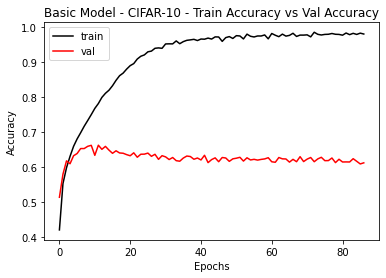

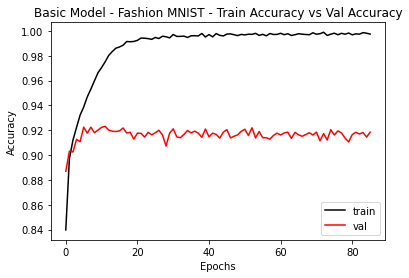

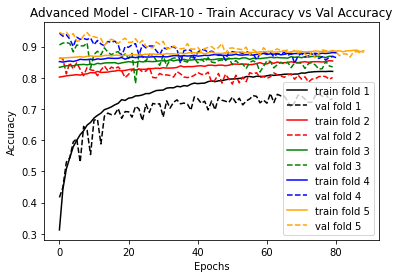

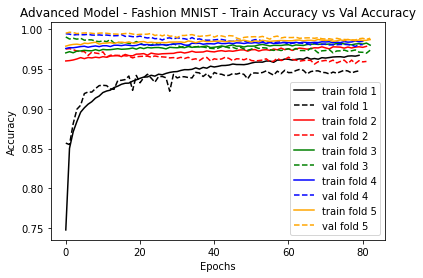

In [8]:
# ==================================================================================================== Step 5. Model Evaluation
# 1. Model Evaluation
# 1.1 Basic Model
color = ["black", "red", "green", "blue", "orange"]
# CIFAR-10
plt.title("Basic Model - CIFAR-10 - Train Accuracy vs Val Accuracy")
plt.plot(model_history_cifar10_basic[0].history['accuracy'], label='train', color=color[0])
plt.plot(model_history_cifar10_basic[0].history['val_accuracy'], label='val', color=color[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("./figures/2 basic_model_cifar10_accuracy.jpg", dpi=600)
plt.show()
# Fashion MNIST
plt.title("Basic Model - Fashion MNIST - Train Accuracy vs Val Accuracy")
plt.plot(model_history_fmnist_basic[0].history['accuracy'], label='train', color=color[0])
plt.plot(model_history_fmnist_basic[0].history['val_accuracy'], label='val', color=color[1])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("./figures/2 basic_model_fmnist_accuracy.jpg", dpi=600)
plt.show()

# 1.2 Advanced Model
# CIFAR-10
plt.title("Advanced Model - CIFAR-10 - Train Accuracy vs Val Accuracy")
for i in range(n_folds):
    plt.plot(model_history_cifar10_advance[i].history['accuracy'], label='train fold ' + str(i + 1), color=color[i])
    plt.plot(model_history_cifar10_advance[i].history['val_accuracy'], label='val fold ' + str(i + 1), color=color[i], linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("./figures/2 advanced_model_cifar10_accuracy.jpg", dpi=600)
plt.show()
# Fashion MNIST
plt.title("Advanced Model - Fashion MNIST - Train Accuracy vs Val Accuracy")
for i in range(n_folds):
    plt.plot(model_history_fmnist_advance[i].history['accuracy'], label='train fold ' + str(i + 1), color=color[i])
    plt.plot(model_history_fmnist_advance[i].history['val_accuracy'], label='val fold ' + str(i + 1), color=color[i], linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("./figures/2 advanced_model_fmnist_accuracy.jpg", dpi=600)
plt.show()

In [9]:
# ==================================================================================================== Step 6. Model Prediction
# 1. Model Prediction
# 1.1 Basic Model
cifar10_test_prediction_basic = basic_model_cifar.predict(cifar10_test_data_normed)
fmnist_test_prediction_basic = basic_model_fmnist.predict(fmnist_test_data_normed)

# 1.2 Advanced Model
cifar10_test_prediction_advanced = advanced_model_cifar.predict(cifar10_test_data_normed)
fmnist_test_prediction_advanced = advanced_model_fmnist.predict(fmnist_test_data_normed)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


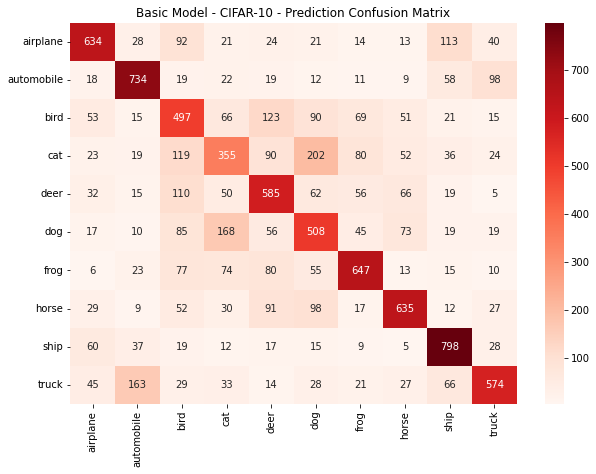

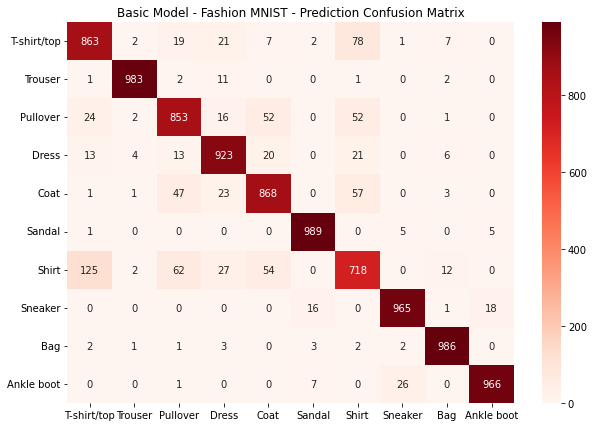

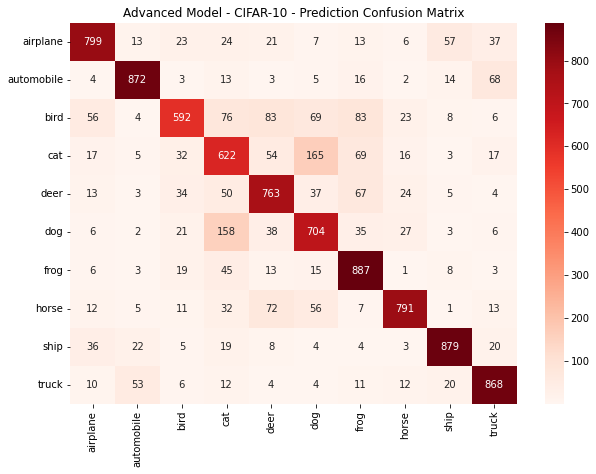

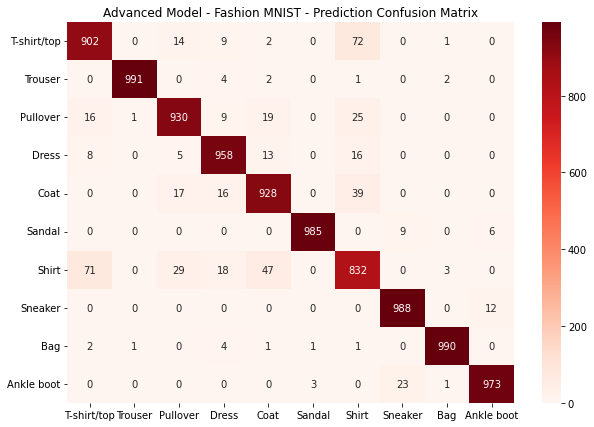

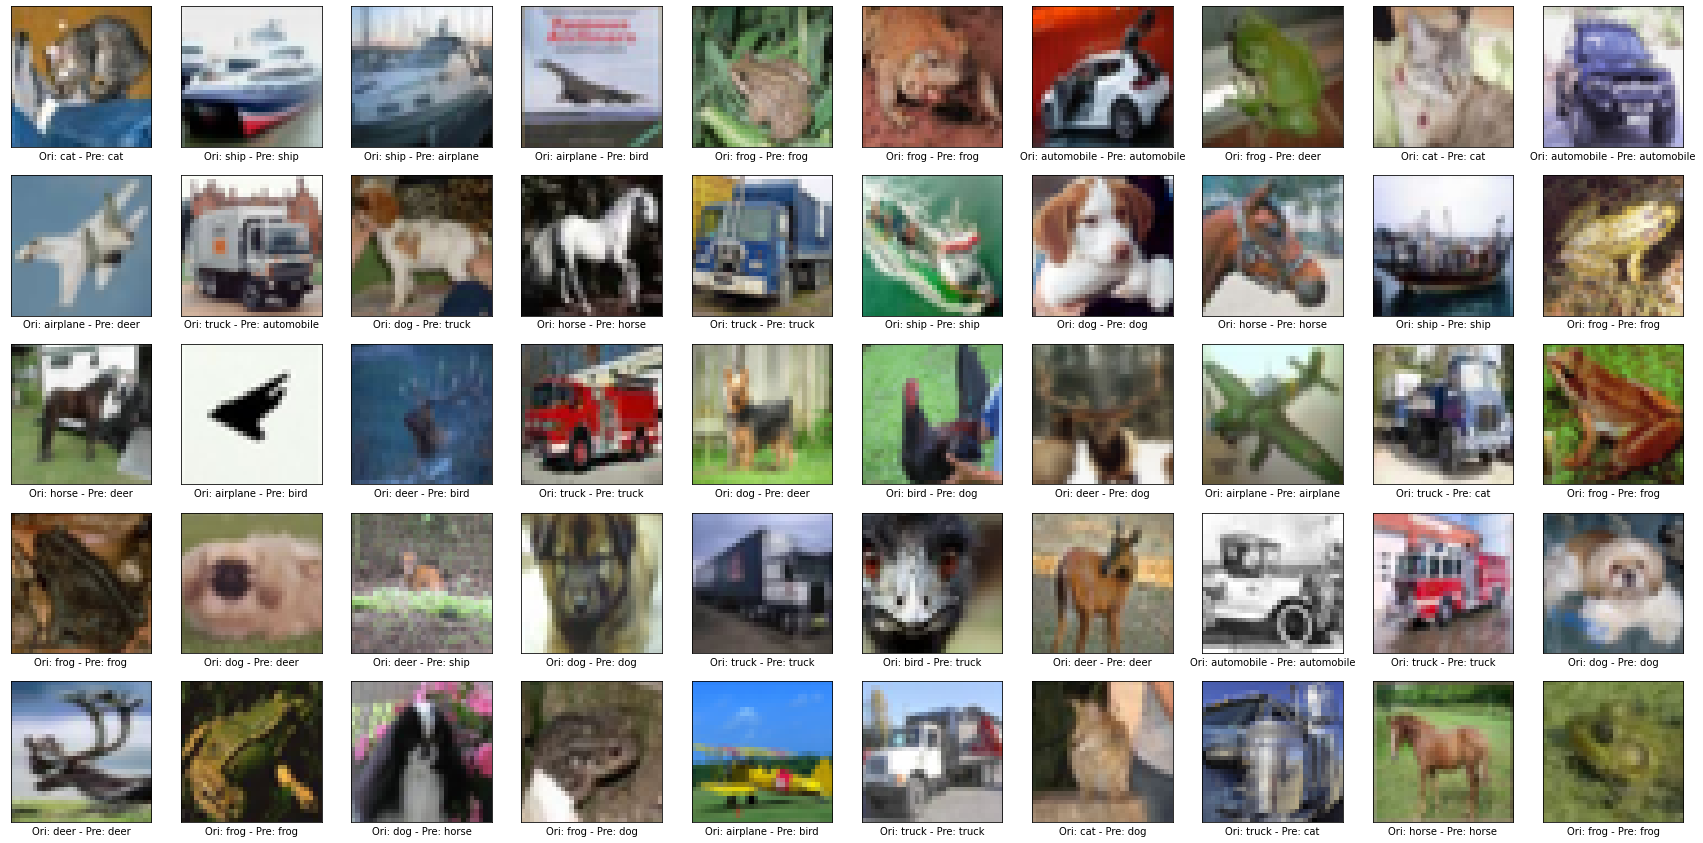

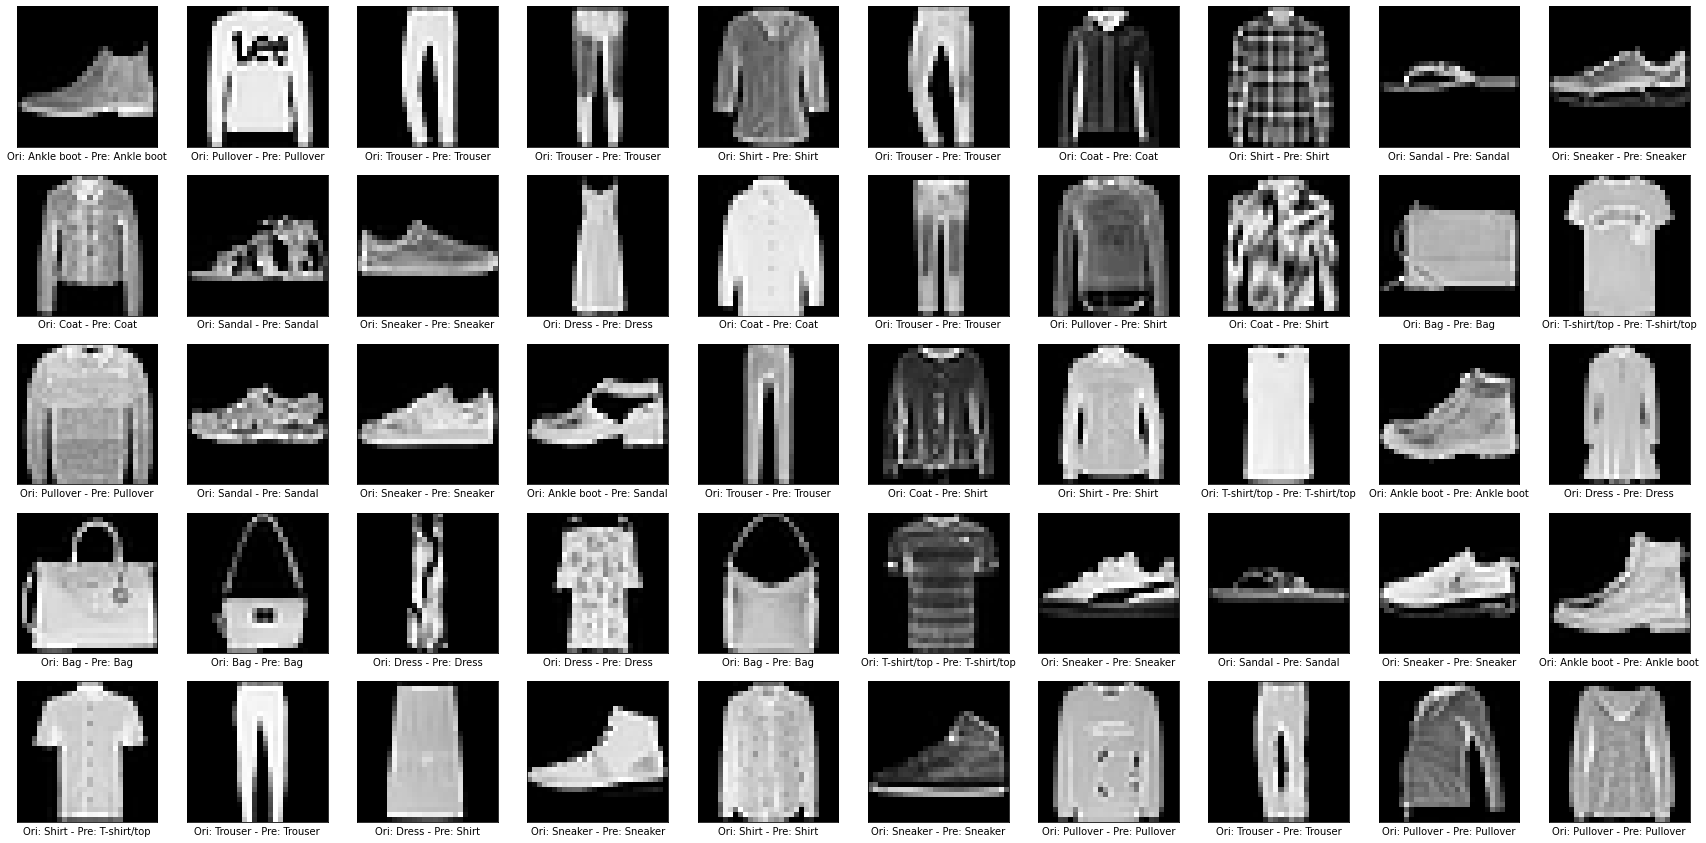

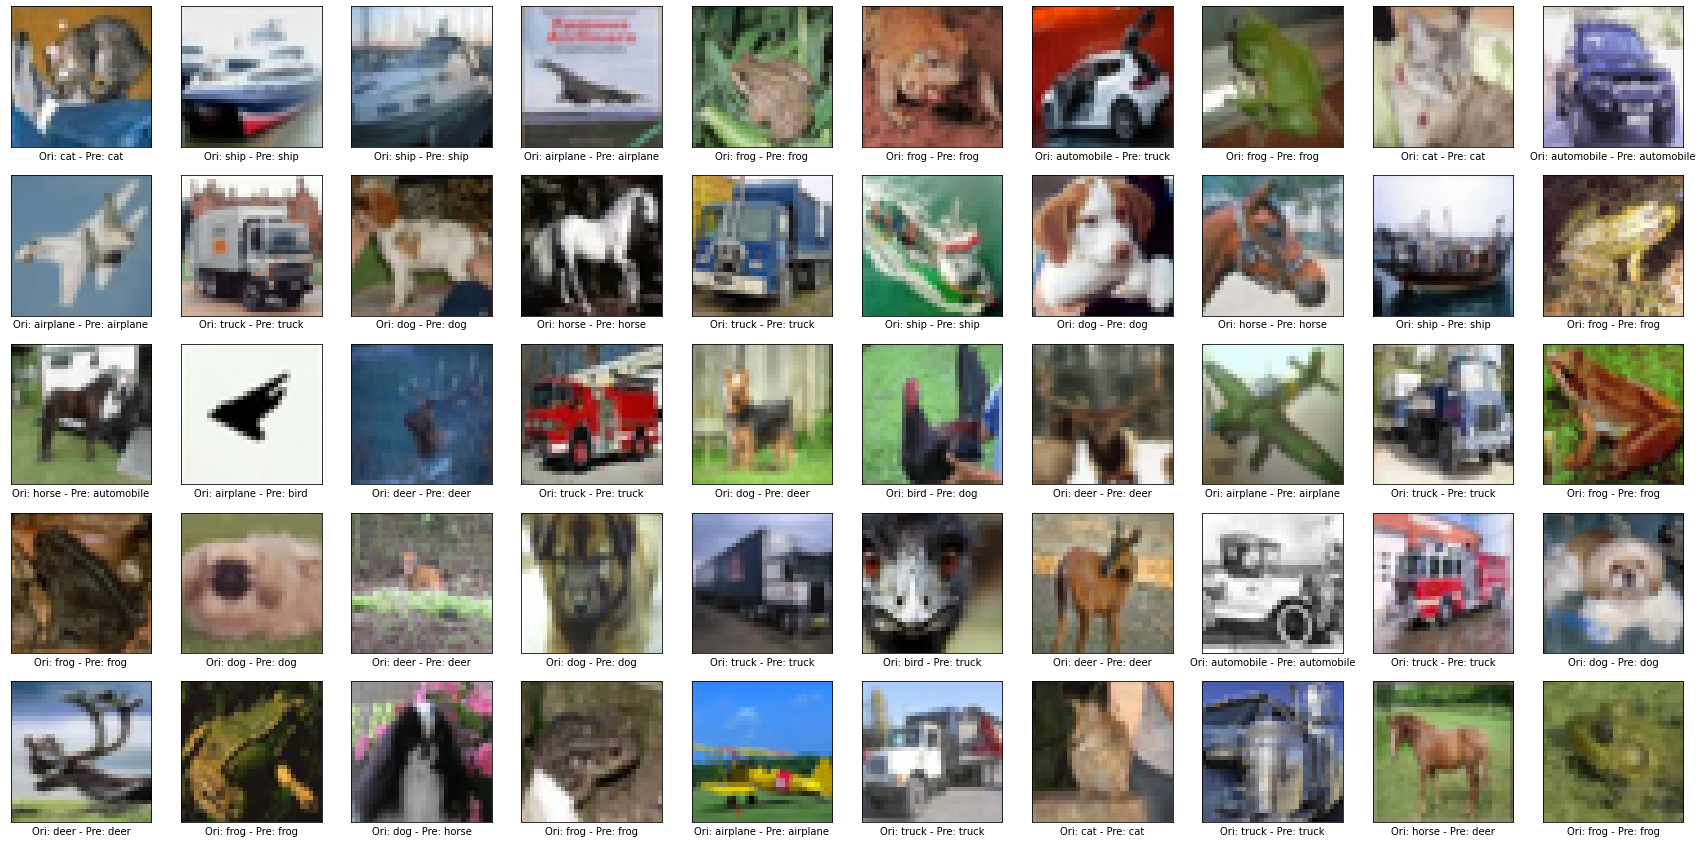

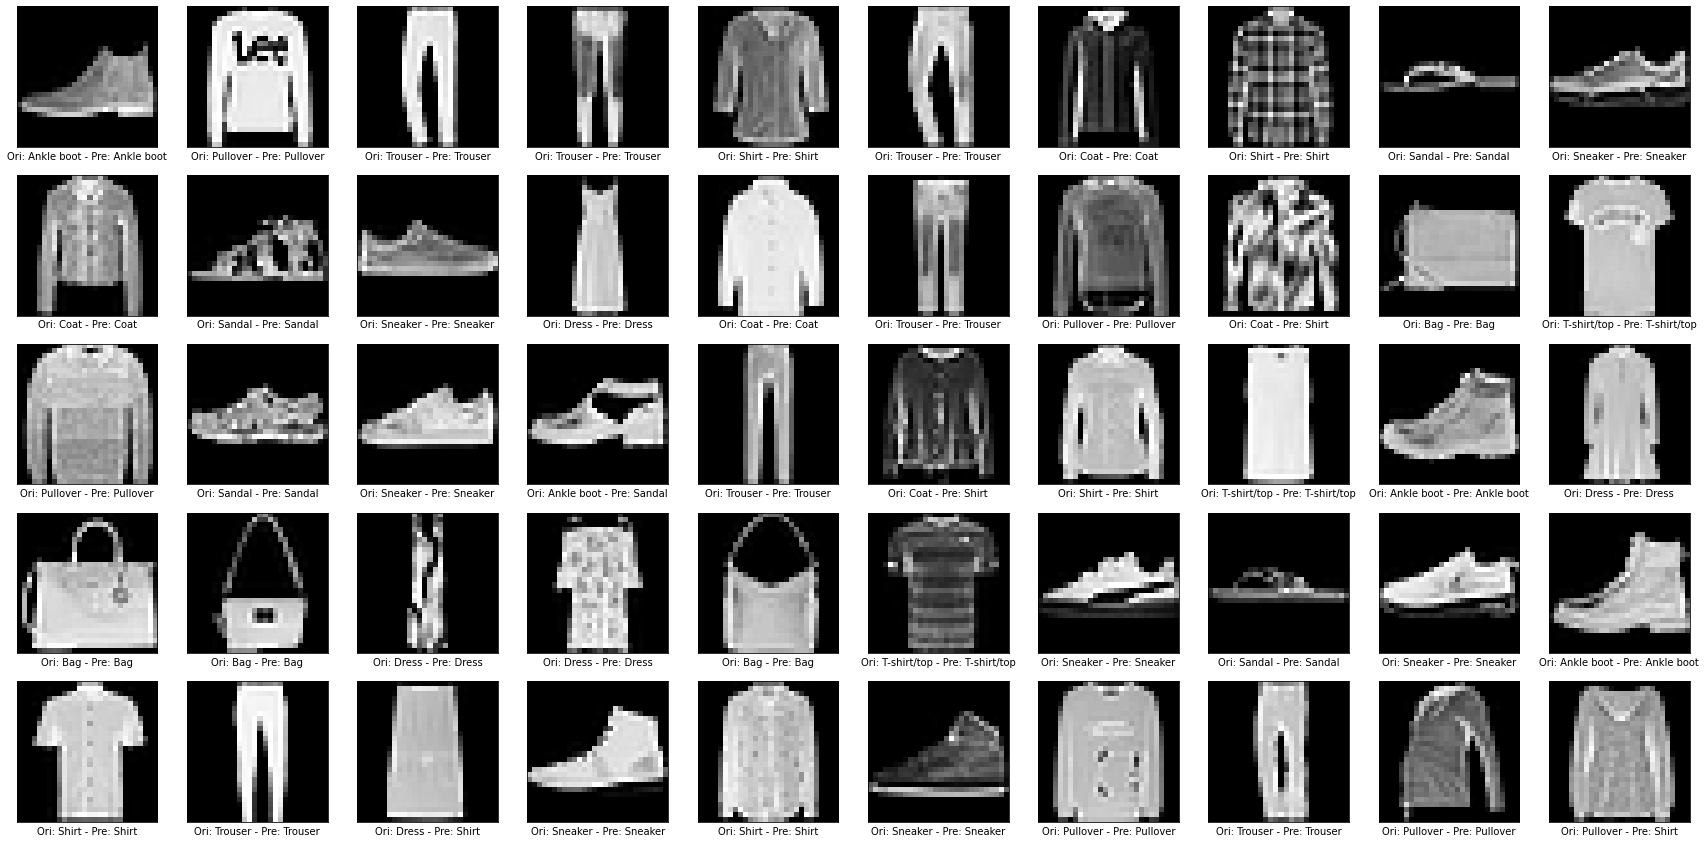

In [ ]:
# ==================================================================================================== Step 7. Prediction Evaluation
# 1. Error Analysis
# for heatmap and confusion matrix
def heatmap(data, row_lbl, col_lbl, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    # Create color bar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    ax.set_xticklabels(col_lbl)
    ax.set_yticklabels(row_lbl)

    # set x and y labels
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar


# to annotate the heatmap
def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center", color="white" if data[i, j] > threshold else "black")
            texts.append(text)

    return texts


# 1.1 Basic Model
# CIFAR-10
cifar10_test_prediction_basic_label = np.argmax(cifar10_test_prediction_basic, axis=1)
cifar10_test_confusion_matrix_basic = confusion_matrix(cifar10_test_label, cifar10_test_prediction_basic_label)
plt.figure(figsize=(10, 7))
sns.heatmap(cifar10_test_confusion_matrix_basic, annot=True, fmt="d", cmap="Reds", xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Basic Model - CIFAR-10 - Prediction Confusion Matrix")
plt.savefig("./figures/3 cifar10_basic_prediction_confusion_matrix.jpg", dpi=600)
plt.show()

# Fashion MNIST
fmnist_test_prediction_basic_label = np.argmax(fmnist_test_prediction_basic, axis=1)
fmnist_test_confusion_matrix_basic = confusion_matrix(fmnist_test_label, fmnist_test_prediction_basic_label)
plt.figure(figsize=(10, 7))
sns.heatmap(fmnist_test_confusion_matrix_basic, annot=True, fmt="d", cmap="Reds", xticklabels=fmnist_classes, yticklabels=fmnist_classes)
plt.title("Basic Model - Fashion MNIST - Prediction Confusion Matrix")
plt.savefig("./figures/3 fmnist_basic_prediction_confusion_matrix.jpg", dpi=600)
plt.show()

# 1.2 Advanced Model
# CIFAR-10
cifar10_test_prediction_advanced_label = np.argmax(cifar10_test_prediction_advanced, axis=1)
cifar10_test_confusion_matrix_advanced = confusion_matrix(cifar10_test_label, cifar10_test_prediction_advanced_label)
plt.figure(figsize=(10, 7))
sns.heatmap(cifar10_test_confusion_matrix_advanced, annot=True, fmt="d", cmap="Reds", xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Advanced Model - CIFAR-10 - Prediction Confusion Matrix")
plt.savefig("./figures/3 cifar10_advanced_confusion_matrix.jpg", dpi=600)
plt.show()

# Fashion MNIST
fmnist_test_prediction_advanced_label = np.argmax(fmnist_test_prediction_advanced, axis=1)
fmnist_test_confusion_matrix_advanced = confusion_matrix(fmnist_test_label, fmnist_test_prediction_advanced_label)
plt.figure(figsize=(10, 7))
sns.heatmap(fmnist_test_confusion_matrix_advanced, annot=True, fmt="d", cmap="Reds", xticklabels=fmnist_classes, yticklabels=fmnist_classes)
plt.title("Advanced Model - Fashion MNIST - Prediction Confusion Matrix")
plt.savefig("./figures/3 fmnist_advanced_confusion_matrix.jpg", dpi=600)
plt.show()


# 2. Display Prediction
# 2.1 Basic Model
# CIFAR-10
plt.figure(figsize=(30, 15))
plt.title("Basic Model - CIFAR-10")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_test_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(f"Ori: {cifar10_classes[cifar10_test_label[i]]} - Pre: {cifar10_classes[np.argmax(cifar10_test_prediction_basic[i])]}")
plt.savefig("./figures/4 cifar10_basic_prediction.jpg", dpi=600)
plt.show()

# Fashion MNIST
plt.figure(figsize=(30, 15))
plt.title("Basic Model - Fashion MNIST")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_test_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(f"Ori: {fmnist_classes[fmnist_test_label[i]]} - Pre: {fmnist_classes[np.argmax(fmnist_test_prediction_basic[i])]}")
plt.savefig("./figures/4 fmnist_basic_prediction.jpg", dpi=600)
plt.show()

# 2.2 Advanced Model
# CIFAR-10
plt.figure(figsize=(30, 15))
plt.title("Advanced Model - CIFAR-10")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cifar10_test_data[i].reshape(3, 32, 32).transpose(1, 2, 0))
    plt.xlabel(f"Ori: {cifar10_classes[cifar10_test_label[i]]} - Pre: {cifar10_classes[np.argmax(cifar10_test_prediction_advanced[i])]}")
plt.savefig("./figures/4 cifar10_advanced_prediction.jpg", dpi=600)
plt.show()

# Fashion MNIST
plt.figure(figsize=(30, 15))
plt.title("Advanced Model - Fashion MNIST")
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fmnist_test_data[i].reshape(28, 28), cmap="gray")
    plt.xlabel(f"Ori: {fmnist_classes[fmnist_test_label[i]]} - Pre: {fmnist_classes[np.argmax(fmnist_test_prediction_advanced[i])]}")
plt.savefig("./figures/4 fmnist_advanced_prediction.jpg", dpi=600)
plt.show()